In [1]:
import tensorflow as tf
import tensorlayer as tl
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import glob

%matplotlib inline

In [2]:
flags = tf.app.flags

flags.DEFINE_string('f', '', 'kernel')          # Weird jupter-notebook 'f' flag

flags.DEFINE_string("checkpoint_dir", "checkpoints/subpixel/", "")
flags.DEFINE_string("sample_dir", "samples/subpixel/", "")
flags.DEFINE_integer("split_stride", 60, "")
flags.DEFINE_integer("scale", 4, "")
flags.DEFINE_integer("image_size", 64, "")
flags.DEFINE_integer("batch_size", 128, "")
flags.DEFINE_integer("num_epochs", 200, "")
flags.DEFINE_float("learning_rate", 1e-4, "")
FLAGS = flags.FLAGS

print(FLAGS.checkpoint_dir)

checkpoints/subpixel/


In [3]:
def _float32_feature(value):
    # reshape value from any dimensions to one dimension, which is the only shape FloatList accepts.
    value = value.flatten()
    return tf.train.Feature(float_list=tf.train.FloatList(value=[float(v) for v in value]))

#
#  Input:
#          hr_dataset_dir: HR image directory,
#          lr_dataset_dir: LR image directory, should includes exactly the same name and number of files with HR image folder
#          target_dir: where it save dataset files
#          dataset_type: it could be 'train', 'valid' or 'test', used as prefix of saved files
#
#  Output:
#          None
#
def preprocess_div2k(hr_dataset_dir, lr_dataset_dir, target_dir, dataset_type='train'):

    # Create the first writer
    savepath = os.path.join(target_dir, '%s_0.tfrecord' % dataset_type)
    writer_options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    writer = tf.python_io.TFRecordWriter(savepath, options=writer_options)

    num_data = 0
    start_time = time.time()
    
    for filename in sorted(os.listdir(hr_dataset_dir)):

        # read files
        name, ext = filename.split(".")
        hr_file = os.path.join(hr_dataset_dir, filename)
        lr_file = os.path.join(lr_dataset_dir, name+'x'+str(FLAGS.scale)+'.'+ext)
        
        hr_image = plt.imread(hr_file)
        lr_image = plt.imread(lr_file)

        # short variables name
        h, w, _ = lr_image.shape
        ls = FLAGS.image_size
        hs = FLAGS.image_size * FLAGS.scale
        
        # split images
        for y in range(0, h-ls+1, FLAGS.split_stride):
            hy = y * FLAGS.scale
            for x in range(0, w-ls+1, FLAGS.split_stride):
                hx = x * FLAGS.scale
                
                x_i = lr_image[y:y+ls, x:x+ls]
                y_i = hr_image[hy:hy+hs, hx:hx+hs]

                # save
                writer.write(tf.train.Example(features=tf.train.Features(feature={
                    'X': _float32_feature(x_i),
                    'Y': _float32_feature(y_i)
                })).SerializeToString())

                num_data += 1
                
                if num_data % 2000 == 0:

                    # flush and close preivous writer
                    writer.flush()
                    writer.close()
                    print("%d %s data have been saved, elapsed %.2f sec" % (num_data, dataset_type, (time.time()-start_time)))
                    start_time = time.time()
                    
                    # create a new file
                    savepath = os.path.join(target_dir, '%s_%d.tfrecord' % (dataset_type, (num_data//2000)))
                    writer = tf.python_io.TFRecordWriter(savepath, options=writer_options)

    writer.flush()
    writer.close()
    print("Total %d %s data have been processed." % (num_data, dataset_type))


# Train data
preprocess_div2k('datasets/DIV2K/DIV2K_train_HR', 'datasets/DIV2K/DIV2K_train_LR',
                 FLAGS.checkpoint_dir, dataset_type='train')

# Validation data
preprocess_div2k('datasets/DIV2K/DIV2K_valid_HR', 'datasets/DIV2K/DIV2K_valid_LR',
                 FLAGS.checkpoint_dir, dataset_type='valid')

Total 1008 train data have been processed.
Total 40 valid data have been processed.


In [3]:
#
# Parse dataset from tfrecord file
#
def _parse_function(example_proto):
    features = {"X": tf.FixedLenFeature([FLAGS.image_size*FLAGS.image_size*3], tf.float32),
                "Y": tf.FixedLenFeature([FLAGS.image_size*FLAGS.image_size*3*FLAGS.scale*FLAGS.scale], tf.float32)
               }
    parsed_features = tf.parse_single_example(example_proto, features)
    data = tf.reshape(parsed_features["X"], [FLAGS.image_size, FLAGS.image_size, 3])
    labels = tf.reshape(parsed_features["Y"], [FLAGS.image_size*FLAGS.scale, FLAGS.image_size*FLAGS.scale, 3])
    return data, labels

[TL] InputLayer  model/input: (?, 64, 64, 3)
[TL] Conv2d model/conv2d: n_filter: 48 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] SubpixelConv2d  model/subpixel_conv2d: scale: 4 n_out_channel: 3 act: No Activation
Epoch:  1, time: 2.99, loss: 2241.16608500
Epoch: 21, time: 6.51, loss: 224.63528439
Epoch: 41, time: 9.23, loss: 104.43742387
Epoch: 61, time: 6.62, loss: 74.47006647
Epoch: 81, time: 9.21, loss: 59.42241754
Epoch: 101, time: 6.47, loss: 59.38655231
Epoch: 121, time: 9.38, loss: 45.38040143
Epoch: 141, time: 6.40, loss: 47.37161100
Epoch: 161, time: 9.50, loss: 44.56048366
Epoch: 181, time: 6.41, loss: 43.81539766
Epoch: 201, time: 9.09, loss: 40.17355852
Epoch: 221, time: 9.03, loss: 45.49504258
Epoch: 241, time: 6.26, loss: 40.22292793
Epoch: 261, time: 9.11, loss: 40.33448175
Epoch: 281, time: 6.32, loss: 37.17411077
[TL] InputLayer  model/input: (?, 64, 64, 3)
[TL] Conv2d model/conv2d: n_filter: 48 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[T

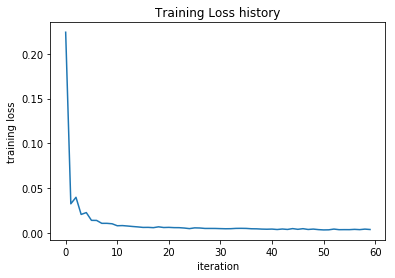

In [17]:
import keras

lr = 1e-2
num_epochs = 300

def model(X, Y, reuse=False):
    with tf.variable_scope("model", reuse=reuse) as vs:
        n = tl.layers.InputLayer(X, name='input')
        n = tl.layers.Conv2d(n, FLAGS.scale*FLAGS.scale*3, act=tf.nn.relu, use_cudnn_on_gpu=True)
        n = tl.layers.SubpixelConv2d(n, scale=FLAGS.scale, name='subpixel_conv2d')
        Y_hat = n.outputs

        loss = tf.reduce_mean(tf.square(Y - Y_hat))
        return Y_hat, loss

def model_keras(X, Y, reuse=False):
    with tf.variable_scope("model_keras", reuse=reuse) as vs:
        model = keras.Seque
    
tf.reset_default_graph()

with tf.Session() as sess:

    # load train dataset
    train_filepath_list = os.path.join(FLAGS.checkpoint_dir, "train_*.tfrecord")
    train_file_list = glob.glob(train_filepath_list)

    # train
    dataset = tf.data.TFRecordDataset(train_file_list, compression_type="GZIP")
    dataset = dataset.map(map_func=_parse_function, num_parallel_calls=4)
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.batch(FLAGS.batch_size)
    dataset = dataset.prefetch(buffer_size=FLAGS.batch_size)
    iterator = dataset.make_initializable_iterator()
        
    # pass training data to model
    batch_images, batch_labels = iterator.get_next()
    
    # model
    y_hat, loss = model(batch_images, batch_labels)
    
    # Set learning rate decay
    step = tf.Variable(0, trainable=False)
    rate = tf.train.exponential_decay(lr, step, 1, 0.9997)
    
    # Use Adam gradient descent
    optimizer = tf.train.AdamOptimizer(rate).minimize(loss, global_step=step)
    
    sess.run(tf.global_variables_initializer())
    sess.run(iterator.initializer)

    loss_hist = []
    start_time = time.time()
    
    for i in range(num_epochs):
        _, _, err = sess.run((optimizer, y_hat, loss))
        
        if i % 5 == 0:
            loss_hist.append(err)

        if i % 20 == 0:
            print("Epoch: %2d, time: %.2f, loss: %.8f" % ((i+1), (time.time()-start_time), (err*10000)))
            start_time = time.time()

    # load validate dataset
    val_filepath_list = os.path.join(FLAGS.checkpoint_dir, "valid_*.tfrecord")
    val_file_list = glob.glob(val_filepath_list)

    # validate
    dataset_val = tf.data.TFRecordDataset(val_file_list, compression_type="GZIP")
    dataset_val = dataset_val.map(map_func=_parse_function, num_parallel_calls=4)
    dataset_val = dataset_val.batch(FLAGS.batch_size)
    iterator_val = dataset_val.make_initializable_iterator()
    
    val_images, val_labels = iterator_val.get_next()

    y_hat, loss = model(val_images, val_labels, True)
    
    sess.run(iterator_val.initializer)
    t = 0.0
    c = 0
    
    while True:
        try:
            predict, err = sess.run((y_hat, loss))
            print(err)
            t += err*1e+4
            c += 1
        except tf.errors.OutOfRangeError:
            break
    
    print("Validation mean error: %.2f" % (t*1e+4/c))
    print(predict.shape)

plt.plot(loss_hist)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

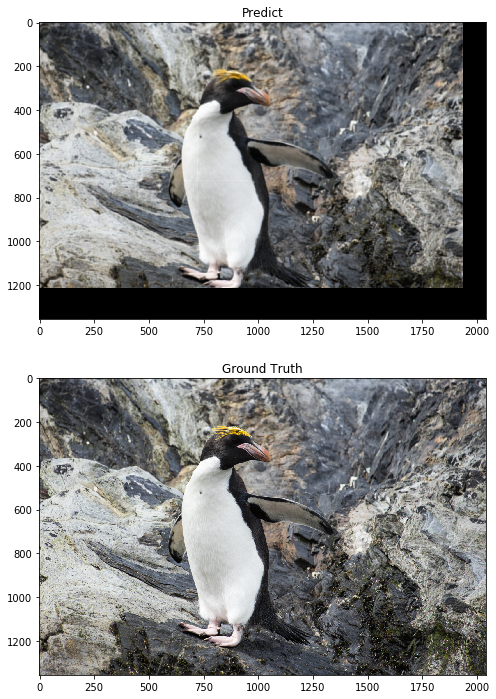

In [16]:
def merge_image(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((size[0], size[1], 3))
    s = FLAGS.split_stride * FLAGS.scale
    num_cols = 1+(size[1]-w+1)//s
    for idx, image in enumerate(images):
        i = idx % num_cols
        j = idx // num_cols
        #print("rows: %d : %d, cols: %d : %d" % (j*s, j*s+h, i*s, i*s+w))
        img[j*s+2:j*s+h-2, i*s+2:i*s+w-2, :] = image[2:-2, 2:-2, :]

    return img

#plt.imsave("example.png", predict[20, :, :, :])

merged_y_hat = merge_image(predict, (1356, 2040))
merged_y_hat[merged_y_hat>1]=0.9999
merged_y_hat[merged_y_hat<0]=0.0
ground_truth_file = plt.imread('datasets/DIV2K/DIV2K_valid_HR/0801.png')

fig = plt.figure(figsize=(16,12))
plt.subplot(211)
plt.title('Predict')
plt.imshow(merged_y_hat)

plt.subplot(212)
plt.title('Ground Truth')
plt.imshow(ground_truth_file)

filename = os.path.join(FLAGS.sample_dir, '0801.png')
plt.imsave(filename, merged_y_hat)

filename = os.path.join(FLAGS.sample_dir, '0801_block.png')
plt.imsave(filename, predict[20, :, :, :])